In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='b', alpha=0.7, s=500)

    return mplleaflet.display()

# leaflet_plot_stations(200,'f730b3be5c0ea89e0421a2cf1f9c2fd2c1bebafae51d00fa2775d250')

In [2]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
from matplotlib.patches import Rectangle
from matplotlib.font_manager import FontProperties
import numpy as np

In [ ]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d200/f730b3be5c0ea89e0421a2cf1f9c2fd2c1bebafae51d00fa2775d250.csv')

In [3]:
df = df[df['ID'] == 'ITM00016061'].iloc[:, 1:].copy() # Data for Turin, Italy

In [4]:
df['Date'] = pd.to_datetime(df['Date']) # Casting date data to datetime format

In [5]:
# Creating a mm-dd column, without the year, for grouping and max/min extraction
df['mm-dd'] = df['Date'].apply(
    lambda x: '{:02d}-{:02d}'.format(
        x.date().month,
        x.date().day
    )
)

In [6]:
# 2005-2014
df_historical = df[
    (df['Date'] >= datetime(2005, 1, 1)) &
    (df['Date'] <= datetime(2014, 12, 31))
]

# 2015
df_2015 = df[
    (df['Date'] >= datetime(2015, 1, 1)) &
    (df['Date'] <= datetime(2015, 12, 31))
]

In [7]:
# Historical max and min data, rescaling from tenths to deg C
df_agg = pd.DataFrame({
    'max': df_historical[df_historical['Element'] == 'TMAX']
        .groupby('mm-dd').max()['Data_Value'] / 10,
    'min': df_historical[df_historical['Element'] == 'TMIN']
        .groupby('mm-dd').min()['Data_Value'] / 10,
    }
)

# 2015 max and min data, rescaling from tenths to deg C
df_2015_agg = pd.DataFrame({
    'max': df_2015[df_2015['Element'] == 'TMAX']
        .groupby('mm-dd').max()['Data_Value'] / 10,
    'min': df_2015[df_2015['Element'] == 'TMIN']
        .groupby('mm-dd').min()['Data_Value'] / 10,
    }
)

# Comparison for over/under
df_compare = pd.merge(
    df_agg,
    df_2015_agg,
    how='outer',
    left_index=True,
    right_index=True,
    suffixes=('', '_2015')
)

In [8]:
# Historical maxima, 2005-2014
historical_maxima = df_agg.loc[:, 'max']
historical_minima = df_agg.loc[:, 'min']

In [9]:
# 2015 over max or under min
max_overshoot_2015 = df_compare[df_compare['max_2015'] > df_compare['max']].loc[:, 'max_2015']
min_overshoot_2015 = df_compare[df_compare['min_2015'] < df_compare['min']].loc[:, 'min_2015']

In [10]:
first_month_days_idx = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
first_month_days_label_pos = [day + 15 for day in first_month_days_idx]

temp_ticks = [i for i in range(-10, 31, 5)]

month_labels = [
    m.upper() for m in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ]
ndays = list(range(len(historical_maxima.index)))

# x locations for 2015 overshoot data points
max_overshoot_2015_x = [list(historical_maxima.index).index(i) for i in max_overshoot_2015.index.values]
min_overshoot_2015_x = [list(historical_maxima.index).index(i) for i in min_overshoot_2015.index.values]

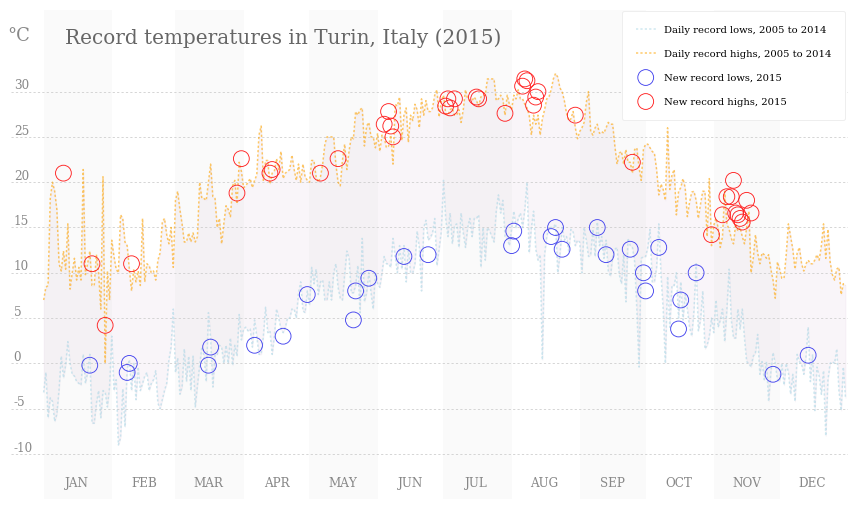

In [11]:
fig, ax = plt.subplots(figsize=(15, 9))

fig.patch.set_facecolor('#ffffff')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks(first_month_days_label_pos)
ax.set_xticklabels(month_labels)

ax.set_yticks(temp_ticks)
ax.set_yticklabels(temp_ticks, fontdict={'size': 12, 'family': 'serif'})

ax.tick_params(
    bottom=False,
    left=False
)

ax.set_title(
    'Record temperatures in Turin, Italy (2015)',
    loc='left', color='#666666', fontdict={'size': 20, 'family': 'serif'},
    y=0.92, x=0.065
)

ax.set_ylabel('°C', rotation=0, color='#888888', fontdict={'size': 18, 'family': 'serif'})
ax.yaxis.set_label_coords(0.01, 0.93)
ax.set_xlim((-15, 366))
ax.set_ylim((-15, 39))


dx = 10/72.; dy = 8/72. 
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    label.set_horizontalalignment("left")
    label.set_color('#888888')

dx = 0/72.; dy = 30/72. 
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    label.set_horizontalalignment("center")
    label.set_color('#888888')
    label.set_fontsize(12)
    label.set_fontname('serif')

ax.grid(axis='y', which='major', ls='dotted', color='#cccccc')
# plt.grid(axis='x', which='major')

ax.plot(
    ndays, historical_minima,
    label='Daily record lows, 2005 to 2014',
    color='lightblue', alpha=0.6, ls='dotted'
)

ax.scatter(
    min_overshoot_2015_x, min_overshoot_2015,
    label='New record lows, 2015',
    s=250, facecolors='none', edgecolors='#4444ee', linewidths=0.9, zorder=100
)

ax.plot(
    ndays, historical_maxima,
    label='Daily record highs, 2005 to 2014',
    color='orange', alpha=0.6, ls='dotted'
)

ax.scatter(
    max_overshoot_2015_x, max_overshoot_2015,
    label='New record highs, 2015',
    s=250, facecolors='none', edgecolors='#ff2222', linewidths=0.9, zorder=100
)

ax.fill_between(
    ndays, historical_minima, historical_maxima,
    color='thistle', alpha=0.15
)

month_colors = ['#fafafa', '#ffffff']

first_month_days_idx_colors = first_month_days_idx + [365]

for idx, (lower, upper) in enumerate(zip(first_month_days_idx_colors[:-1], first_month_days_idx_colors[1:])):
    color = month_colors[idx % 2]
    ax.add_patch(
        Rectangle((lower, -25), upper, 65, color=color, zorder=0)
    )
    
font = FontProperties(family='serif')

ax.legend(loc=(0.73, 0.775), framealpha=1, borderpad=1.4, labelspacing=1.5, edgecolor='#eeeeee', prop=font)